In [3]:
!pip install clint

  Created wheel for clint: filename=clint-0.5.1-py3-none-any.whl size=34448 sha256=4647bf25f72e80b1dbca22ec2eac1322b55a25b0d8f3bf50a88c91c6e35246ff
  Stored in directory: /home/jovyan/.cache/pip/wheels/84/c4/6d/3235262e25e25ce8f080be07d9181853c92e0be64bb1a5d219
  Created wheel for args: filename=args-0.1.0-py3-none-any.whl size=3317 sha256=bb906e2ddda0c96440a36e660b8741b8c242babdcb9302288c79c6fd6a05ef5c
  Stored in directory: /home/jovyan/.cache/pip/wheels/08/5b/6a/d4c08f9d355023389016ed57db4099cf7091627fd5de717da6
Successfully built clint args


In [43]:
import gzip
import shutil
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from clint.textui import progress
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from datetime import timedelta
from time import time
import seaborn as sns

In [36]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>5.2f}'

In [5]:
Path('data')

PosixPath('data')

In [6]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

In [7]:
FTP_URL = 'ftp://emi.nasdaq.com/ITCH/Nasdaq_ITCH/'
SOURCE_FILE = '03272019.NASDAQ_ITCH50.gz'

In [8]:
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    filename = data_path / url.split('/')[-1]
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)
    unzipped = data_path / (filename.stem + '.bin')
    if not (data_path / unzipped).exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    return unzipped


In [9]:
file_name = may_be_download(urljoin(FTP_URL, SOURCE_FILE))
date = file_name.name.split('.')[0]

Unzipping to data/03272019.NASDAQ_ITCH50.bin


In [10]:
date

'03272019'

In [11]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

In [12]:
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

In [13]:
formats = {
    ('integer', 2): 'H', # int of length 2 => format string 'H'
    ('integer', 4): 'I',
    ('integer', 6): '6s', # int of length 6 => parse as string, convert later

    ('integer', 8): 'Q',
    ('alpha', 1)  : 's',
    ('alpha', 2)  : '2s',
    ('alpha', 4)  : '4s',
    ('alpha', 8)  : '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

In [15]:
message_data = (pd.read_excel('message_types.xlsx',
                              sheet_name='messages')
                .sort_values('id')
                .drop('id', axis=1))



In [16]:
message_data.head()

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below


In [17]:
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = df.value.str.strip()
    df.name = (df.name
               .str.strip() # remove whitespace
               .str.lower()
               .str.replace(' ', '_')
               .str.replace('-', '_')
               .str.replace('/', '_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

In [18]:
message_types = clean_message_types(message_data)

In [19]:
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
# message_labels.to_csv('message_labels.csv', index=False)
message_labels.head()



,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


In [21]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name != 'message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))
message_types.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [22]:
message_types.head()

,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


In [23]:
message_types.to_csv('message_types.csv', index=False)

In [24]:
message_types = pd.read_csv('message_types.csv')

In [25]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                            .apply(tuple, axis=1).map(formats))


In [26]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

In [27]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())


In [29]:
alpha_fields.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, event_code to price_variation_indicator
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   offset        45 non-null     int64 
 1   length        45 non-null     int64 
 2   value         45 non-null     object
 3   notes         45 non-null     object
 4   message_type  45 non-null     object
 5   formats       45 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB


In [30]:
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

In [31]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if m == 'R':
                dc.append('stock')
            try:
                store.append(mtype,
                         data,
                         format='t',
                         min_itemsize=s,
                         data_columns=dc)
            except Exception as e:
                print(e)
                print(mtype)
                print(data.info())
                print(pd.Series(list(m.keys())).value_counts())
                data.to_csv('data.csv', index=False)
                return 1
    return 0

In [34]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

In [37]:
start = time()
with file_name.open('rb') as data:
    while True:

        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)
        
        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')        
        message_type_counter.update([message_type])

        # read & store message
        record = data.read(message_size - 1)
        message = message_fields[message_type]._make(unpack(fstring[message_type], record))
        messages[message_type].append(message)
        
        # deal with system events
        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break
        message_count += 1

        if message_count % 2.5e7 == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
            res = store_messages(messages)
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

print('Duration:', format_time(time() - start))



 Start of Messages
	03:02:31.07	           0

 Start of System Hours
	04:00:00.00	     219,327

 Start of Market Hours
	09:30:00.00	  11,818,063
	09:39:31.14	  25,000,000	00:03:02.97
	09:57:14.99	  50,000,000	00:18:02.95
	10:18:35.62	  75,000,000	00:31:41.33
	10:41:29.75	 100,000,000	00:47:34.89
	11:00:23.93	 125,000,000	01:02:15.85
	11:21:45.48	 150,000,000	01:16:31.57
	11:41:28.56	 175,000,000	01:30:09.99
	12:01:10.42	 200,000,000	01:44:03.01
	12:23:19.75	 225,000,000	01:57:30.54
	12:49:58.36	 250,000,000	02:11:24.41
	13:18:58.14	 275,000,000	02:25:05.15
	13:50:59.09	 300,000,000	02:38:31.87
	14:24:40.54	 325,000,000	03:34:45.41
	14:55:33.94	 350,000,000	03:48:18.55
	15:25:11.75	 375,000,000	04:01:45.76
	15:50:06.33	 400,000,000	04:15:02.61

 End of Market Hours
	16:00:00.00	 419,555,641

 End of System Hours
	20:00:00.00	 422,232,228

 End of Messages
	20:05:00.00	 422,264,304
Duration: 06:12:04.35


In [38]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
counter

,Message Type,# Trades
A,add_order_no_mpid_attribution,186296811
D,order_delete,181953144
U,order_replace,34555656
E,order_executed,7331047
X,order_cancel,5495709
I,noii,3674503
F,add_order_mpid_attribution,1477447
P,trade,1105314
L,market_participant_position,193290
C,order_executed_with_price,137556


In [39]:
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)


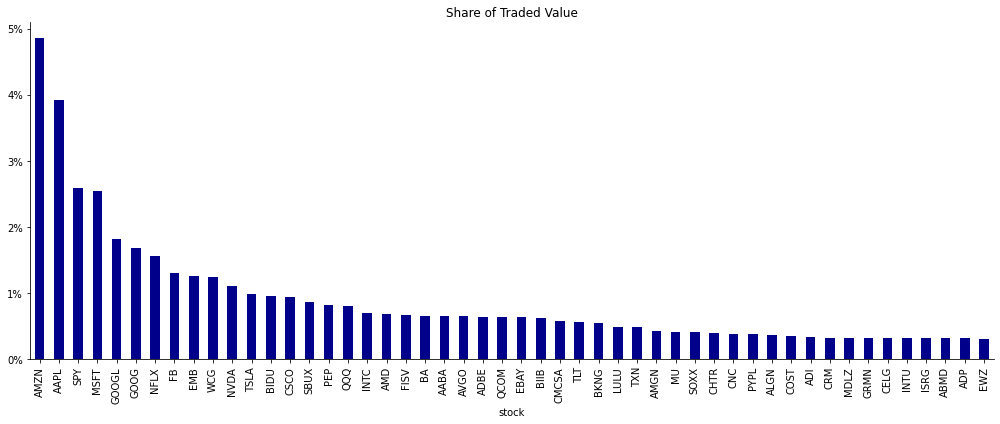

In [44]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()



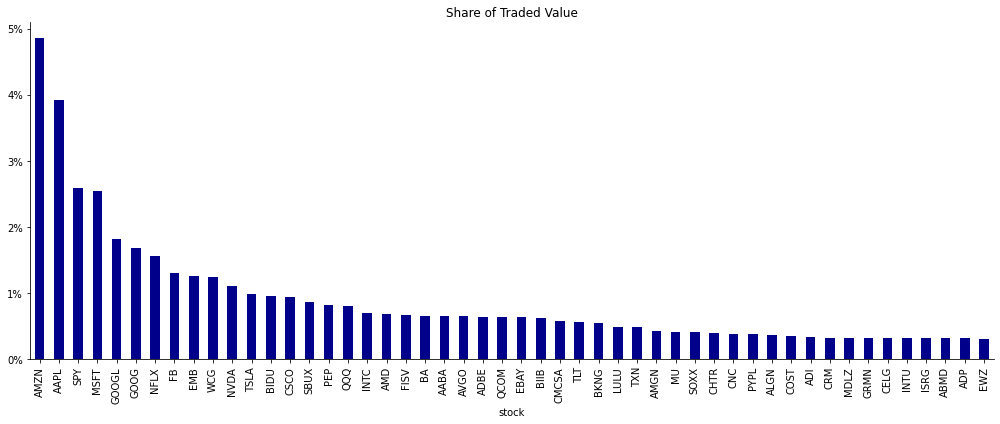

In [45]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()

In [47]:
trades.to_csv('trades.csv', index=False)

In [48]:
trade_summary.to_csv('trade_summary.csv', index=False)

In [49]:
counter.to_csv('counter.csv', index=False)

In [50]:
data.to_csv('new_data.csv', index=False)

AttributeError: '_io.BufferedReader' object has no attribute 'to_csv'

In [56]:
# df_final = pd.read_hdf(itch_store)

In [57]:
# hdf = pd.HDFStore(itch_store, 'r')

In [51]:
pd.HDFStore(itch_store)

<class 'pandas.io.pytables.HDFStore'>
File path: data/itch.h5

In [ ]:
# livro de ordens que é atualizado em tempo real

In [ ]:
# Market depth is a key indicator of liquidity and the potential price impact of sizable market orders.